In [171]:
from configparser import ConfigParser, ExtendedInterpolation
                                                                                                                                                                                
import scipy.io
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
import pyspike
import os
import joblib
import warnings
import shutil

import multiprocessing as mp

from ipywidgets import IntSlider, interact, Dropdown, fixed
from spikelib import spiketools as spkt

import scipy.cluster as cluster
import scipy.spatial.distance as distance
from scipy.spatial.distance import squareform
import sklearn.metrics.cluster as metrics
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

from tqdm import tqdm
from chirp import get_chirp_subevents, get_pop_response, chirp_def_args, chirp_generator
import json

%matplotlib inline
config = ConfigParser(interpolation=ExtendedInterpolation())

2100

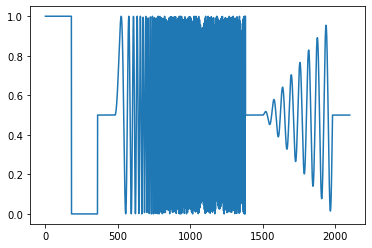

In [172]:
chirp_stimuli = chirp_generator(1/60, chirp_def_args())
s_stimuli = chirp_stimuli["full_signal"]
s_on_off = chirp_stimuli["on_off"]
#stimuli = np.concatenate([s_on_off[1], s_on_off[1], s_stimuli ])
stimuli = s_stimuli
plt.plot(stimuli)
len(stimuli)

In [246]:
def get_cell_trials(chirp_trials, flash_trials, chirp_time, flash_time, chirp_psth, flash_psth, exp, uidx, stimuli, indexer):
    fig = plt.figure(figsize=(16,20))

    plot_stims = [0,1]
    plot_widths = [1.2,0.8,3]
    
    m_c = np.max(chirp_trials) + 5
    m_f = np.max(flash_trials) + 5
    
    gs = gridspec.GridSpec(23, 3, width_ratios = plot_widths, wspace=0.1, hspace=0.1)
    
    if(indexer == 0):
        if os.path.isdir('../results/full_rep/ON/{}/'.format(exp)) == False:
            os.mkdir('../results/full_rep/ON/{}/'.format(exp))
        cls_folder = '../results/full_rep/ON/'
        
    if(indexer == 1):
        if os.path.isdir('../results/full_rep/OFF/{}/'.format(exp)) == False:
            os.mkdir('../results/full_rep/OFF/{}/'.format(exp))
        cls_folder = '../results/full_rep/OFF/'
        
    if(indexer == 2):
        if os.path.isdir('../results/full_rep/ON-OFF/{}/'.format(exp)) == False:
            os.mkdir('../results/full_rep/ON-OFF/{}/'.format(exp))
        cls_folder = '../results/full_rep/ON-OFF/'
        
    if(indexer == 3):
        if os.path.isdir('../results/full_rep/Null/{}/'.format(exp)) == False:
            os.mkdir('../results/full_rep/Null/{}/'.format(exp))
        cls_folder = '../results/full_rep/Null/'
        
        
        
    for i in range(len(chirp_trials)):
        ax = plt.subplot(gs[i , 2])
        ax.plot(chirp_time, chirp_trials[i])

        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_ylim([0 , m_c])
        
        if(i==0):
            ax.set_title("Chirp Response", fontsize=20)
        
        
        ax = plt.subplot(gs[i , 1])
        ax.plot(flash_time, flash_trials[i])

        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_ylim([0 , m_f])
        
        if(i==0):
            ax.set_title("Color Response", fontsize=20)
        
        ax = plt.subplot(gs[i , 0])
        ax.set_title("Trial {}".format(i+1), y = 0.35)
        plt.xticks(())
        plt.yticks(())
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    ax = plt.subplot(gs[21, 1])
    ax.plot(flash_time, flash_psth)

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax = plt.subplot(gs[21 , 2])
    ax.plot(chirp_time, chirp_psth)

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax = plt.subplot(gs[21 , 0])
    ax.set_title("Final PSTH", y = 0.35)
    plt.xticks(())
    plt.yticks(())
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax = plt.subplot(gs[22 , 0])
    ax.set_title("Stimuli", y = 0.35)
    plt.xticks(())
    plt.yticks(())
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax = plt.subplot(gs[22 , 2])
    ax.plot(stimuli)
    plt.xticks(())
    plt.yticks(())
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax = plt.subplot(gs[22 , 1])
    ax.plot(np.concatenate([stimuli[0:360], stimuli[0:360]]))
    plt.xticks(())
    plt.yticks(())
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
            
    plt.savefig('{}/{}/{}.png'.format(cls_folder, exp, uidx))
    fig.clf()
    plt.close(fig)
    
    return gs

In [247]:
rootdir = os.getcwd()
with open("params.json") as p:
    params = json.load(p)
    
# Create output folder if it does not exist
if os.path.isdir(params['Output']) == False:
    os.mkdir(params['Output'])

In [248]:
exp_unit = []
spiketimes = []
chirp_psth = []
flash_psth = []
bias_index = []
pcells = None

ctype_map = {'ON': 0, 'OFF': 1, 'ON/OFF': 2, 'Null': 3}

for exp_path in params['Experiments']:
    os.chdir(exp_path)
    cfg_file = 'config.ini'
    config.read(cfg_file)
    
    config.set('PROJECT', 'path', '{}/'.format(os.getcwd()))
    with open(cfg_file, 'w+') as configfile:
        config.write(configfile)
    config.read(cfg_file)

    os.chdir(rootdir)
    exp_path = config['PROJECT']['path']
    exp = config['EXP']['name']
    sorting_file = config['FILES']['sorting']
    sync_file = config['SYNC']['events']
    start_end_path = config['SYNC']['frametime']
    repeated_path = config['SYNC']['repeated']
    sub_events_path = os.path.join(config['SYNC']['folder'],
                               'sub_event_list_{}_chirp.csv'.format(exp))
    output_features = os.path.join(config['SYNC']['folder'],
                                   'chirp_features_{}.csv'.format(exp))

    sorting = config['FILES']['sorting']
        
#     times = [3, 3, 2, 15, 2, 8, 2]
#     names = ['ON', 'OFF', 'adap_0', 'FREQ', 'adap_1', 'AMP', 'adap_2']

    names = ['ON', 'OFF', 'adap_0', 'FREQ', 'FREQ_FAST','adap_1', 'AMP', 'adap_2']
    times = [3, 3, 2, 5, 10, 2, 8, 2] # WARNING: freq time modded
    
    sr = 20000.0 / 1000.0  
    fields_df = ['start_event', 'end_event']
    cfields_df = ['start_event', 'start_next_event']
    #Colors
    events = pd.read_csv(sync_file)  
    col_mask = events['protocol_name'] == 'flash'

    blue_mask = col_mask & (events['extra_description'] == 'blue')
    green_mask = col_mask & (events['extra_description'] == 'green')

    blue_time = np.array(events[blue_mask][cfields_df]) / sr
    green_time = np.array(events[green_mask][cfields_df]) / sr
       
    blue_dur = np.max(np.diff(blue_time[:-1], axis=1))
    green_dur = np.max(np.diff(green_time[:-1], axis=1))
    color_dur = blue_dur + green_dur
    
    blue_time[-1][1] = blue_time[-1][0] + blue_dur
    green_time[-1][1] = green_time[-1][0] + green_dur
    
    # Full field chirp
#     events = pd.read_csv(sync_file)
#     chirp_mask = events['protocol_name'] == 'chirp'
#     bound_time = np.array(events[chirp_mask][fields_df]) / sr
    
    # Segmented chirp
#     events = pd.read_csv(sub_events_path, sep=';')

    # May be errors while processing due invalid files
    events = get_chirp_subevents(sync_file, start_end_path, repeated_path, sub_events_path, names, times)
    if isinstance(events, pd.DataFrame) is not True:
        print('Error computing chirp sub events')
        continue
        
    chirp_mask = events['protocol_name'] == 'chirp'

    mask_on = (events['extra_description'] == 'ON') & chirp_mask
    mask_off = (events['extra_description'] == 'OFF') & chirp_mask
    mask_freq = (events['extra_description'] == 'FREQ') & chirp_mask
    mask_adap1 = (events['extra_description'] == 'adap_1') & chirp_mask
    mask_amp = (events['extra_description'] == 'AMP') & chirp_mask
    mask_adap2 = (events['extra_description'] == 'adap_2') & chirp_mask # Using as final chirp times and for amplitude mod

    on_time = np.array(events[mask_on][fields_df]) / sr
    off_time = np.array(events[mask_off][fields_df]) / sr
    freq_time = np.array(events[mask_freq][fields_df]) / sr
    adap1_time = np.array(events[mask_adap1][fields_df]) / sr
    amp_time = np.array(events[mask_amp][fields_df]) / sr
    adap2_time = np.array(events[mask_adap2][fields_df]) / sr # adap times after amplitude modulation

#     bound_time = np.array(events[chirp_mask][fields_df]) / sr
    bound_time = np.array([freq_time[:, 0], adap2_time[:, 1]]).T
    flash_bound = np.array([on_time[:, 0], off_time[:, 1]]).T / 1000

#     chirp_dur = np.mean(np.diff(bound_time, axis=1))
    chirp_dur = 35 
    
    def format_to_pyspike(trials, stim_dur):
        st = []
        for t in trials:
            st.append(pyspike.SpikeTrain(t, stim_dur))
        return st

    psth_bin = 0.06  # In sec
    fit_resolution = 0.001  # In sec

    chirp_time = np.linspace(0, chirp_dur, int(np.ceil((chirp_dur) / fit_resolution)))
    chirp_bins = np.linspace(0, chirp_dur, int(np.ceil((chirp_dur) / psth_bin)))

    
    flash_dur = 6
    flash_time = np.linspace(0, flash_dur, int(np.ceil((flash_dur) / fit_resolution)))
    flash_bins = np.linspace(0, flash_dur, int(np.ceil((flash_dur) / psth_bin)))
    
    color_dur_2 = 12
    color_time = np.linspace(0, color_dur_2, int(np.ceil((color_dur_2) / fit_resolution)))
    color_bins = np.linspace(0, color_dur_2, int(np.ceil((color_dur_2) / psth_bin)))

    filtered_cells = 0

    
    with h5py.File(sorting, 'r') as spks:
        idxs = list(spks['spiketimes'].keys())
        uidx = ['Unit_{:04d}'.format(int(i.split('_')[1]) + 1) for i in idxs]
        
        nspikes = {}
        for s in spks['spiketimes']:
            nspikes[s] = spks['spiketimes'][s][:]
        
        print('{} reading:'.format(exp))
        feat = get_pop_response(nspikes, events, chirp_def_args(), psth_bin, fit_resolution)
        feat['exp'] = exp        
        if pcells is None: pcells = feat.reset_index()
        else: pcells = pcells.append(feat.reset_index(), ignore_index=True)
        
        for i, idx in enumerate(idxs):
#             trials = spkt.get_trials(np.unique(spks['spiketimes'][idx][:].flatten() / sr), bound_time[:, 0], bound_time[:, 1])
            if feat['QI'][uidx[i]] < 0.25:
               filtered_cells += 1
               continue
            
            trials = []
            trials_color = []
            sec_trials = []
            sec_trials_color = []
            chirp_trials_cell = []
            flash_trials_cell = []
            
            chirp_trials = spkt.get_trials(np.unique(spks['spiketimes'][idx][:].flatten() / sr), on_time[:, 0], adap2_time[:, 1])
            #Blue flash
            blue_trials = spkt.get_trials(np.unique(spks['spiketimes'][idx][:].flatten() / sr), blue_time[:, 0], blue_time[:, 1])
            #Green flash
            green_trials = spkt.get_trials(np.unique(spks['spiketimes'][idx][:].flatten() / sr), green_time[:, 0], green_time[:, 1])

            for (b, g, c) in zip(blue_trials, green_trials, chirp_trials):
#                 t = np.concatenate([b, g + blue_dur, f+color_dur, a + color_dur+ 13100])
                #t = np.concatenate([b, g + blue_dur, c + color_dur])
                t = c
                t_color = np.concatenate([b, g + blue_dur])
                trials.append(t)
                trials_color.append(t_color)
                sec_trials.append(t / 1000)
                sec_trials_color.append(t_color / 1000)
                
                m = np.zeros_like(t, dtype=bool)
                m[np.unique(t, return_index=True)[1]] = True
                if t[~m].shape[0] > 0:
                    print(t[~m])

            low_spikes = False
            for t in trials:
                if t.shape[0] < 20:
                    low_spikes = True
                    break        
            if low_spikes:
                filtered_cells += 1
                continue
                
            indexer = ctype_map[feat[feat.index == uidx[i]].flash_type[0]]
            
            for j in range(len(trials)):
                
                (psth, _) = np.histogram(trials[j] / 1000, bins=chirp_bins)
                chirp_resp = spkt.est_pdf([trials[j]/ 1000], chirp_time, bandwidth=psth_bin, norm_factor=psth.max())                   
                chirp_trials_cell.append(chirp_resp)

                (psth, _) = np.histogram(trials_color[j]/1000, bins=color_bins)
                flash_resp = spkt.est_pdf([trials_color[j]/1000], color_time, bandwidth=psth_bin, norm_factor=psth.max())

                flash_trials_cell.append(flash_resp)
                    
            #BIAS INDEX
            bias_index.append(feat["bias_idx"][uidx[i]])
            
            spikes_color = spkt.flatten_trials(trials_color)
            (psth, _) = np.histogram(spikes_color / 1000, bins=color_bins)
            color_resp = spkt.est_pdf(sec_trials_color , color_time, bandwidth=psth_bin, norm_factor=psth.max())
            

            spikes_chirp = spkt.flatten_trials(sec_trials)
            (psth, _) = np.histogram(spikes_chirp, bins=chirp_bins)
            chirp_resp = spkt.est_pdf(sec_trials, chirp_time, bandwidth=psth_bin, norm_factor=psth.max())
            
            exp_unit.append((exp, uidx[i], idx))
            spiketimes.append(np.asarray(format_to_pyspike(trials, (chirp_dur) * 1000), dtype=object))
            chirp_psth.append(chirp_resp)
            
            # Flash signal for plotting later
            trials = spkt.get_trials(np.unique(spks['spiketimes'][idx][:].flatten() / sr) / 1000, flash_bound[:, 0], flash_bound[:, 1])
            spikes_flash = spkt.flatten_trials(trials)
            (psth, _) = np.histogram(spikes_flash, bins=flash_bins)
            flash_resp = spkt.est_pdf(trials, flash_time, bandwidth=psth_bin, norm_factor=psth.max())
            flash_psth.append(flash_resp)
#           
#                
            gs = get_cell_trials(chirp_trials_cell, flash_trials_cell, chirp_time, color_time, chirp_resp, color_resp, exp, uidx[i], stimuli, indexer)
#                 plt.close()
#                 plt.cla()
#                 plt.clf()
    
    print('{} cells below minimum spikes constraint.'.format(filtered_cells))
    print('{} cells valid for {}\n'.format(len(uidx) - filtered_cells, exp))

chirp_psth = np.asarray(chirp_psth)
flash_psth = np.asarray(flash_psth)
print('Total cells for clustering: {}'.format(len(exp_unit)))
                


cols = pcells.columns.tolist()
pcells = pcells[cols[-1:] + cols[:-1]]

MR-0296 reading:


Saving info: 100%|█████████████████████████████████████████████| 614/614 [00:00<00:00, 85238.23it/s]


476 cells below minimum spikes constraint.
138 cells valid for MR-0296

MR-0298 reading:


Saving info: 100%|█████████████████████████████████████████████| 699/699 [00:00<00:00, 97337.93it/s]


621 cells below minimum spikes constraint.
78 cells valid for MR-0298

MR-0299 reading:


Saving info: 100%|████████████████████████████████████████████| 464/464 [00:00<00:00, 127399.65it/s]


367 cells below minimum spikes constraint.
97 cells valid for MR-0299

MR-0300 reading:


Saving info: 100%|█████████████████████████████████████████████| 597/597 [00:00<00:00, 74594.84it/s]


493 cells below minimum spikes constraint.
104 cells valid for MR-0300

MR-0303 reading:


Saving info: 100%|█████████████████████████████████████████████| 766/766 [00:00<00:00, 90250.76it/s]


554 cells below minimum spikes constraint.
212 cells valid for MR-0303

MR-0306 reading:


Saving info: 100%|█████████████████████████████████████████████| 724/724 [00:00<00:00, 90208.12it/s]


541 cells below minimum spikes constraint.
183 cells valid for MR-0306

MR-0307 reading:


Saving info: 100%|█████████████████████████████████████████████| 461/461 [00:00<00:00, 77457.60it/s]


381 cells below minimum spikes constraint.
80 cells valid for MR-0307

MR-0309 reading:


Saving info: 100%|█████████████████████████████████████████████| 457/457 [00:00<00:00, 93868.61it/s]


356 cells below minimum spikes constraint.
101 cells valid for MR-0309

MR-0311 reading:


Saving info: 100%|█████████████████████████████████████████████| 484/484 [00:00<00:00, 77621.81it/s]


458 cells below minimum spikes constraint.
26 cells valid for MR-0311

Total cells for clustering: 1019


In [178]:
import shutil

#cls_folder = '{}clust_bias/clust_{}'.format(params['Output'], exp)
cls_folder = '{}clust_bias_filt/cluts_exps'.format(params['Output'])
print(cls_folder)

if os.path.isdir(cls_folder) == False:
    os.mkdir(cls_folder)
else:
    shutil.rmtree(cls_folder)
    os.mkdir(cls_folder)
    
np.save('{}/chirp_psth.npy'.format(cls_folder), chirp_psth)
np.save('{}/flash_psth.npy'.format(cls_folder), flash_psth)

../results/clust_bias_filt/cluts_exps


In [179]:
num_threads = 48

def flat_unit_pairs(st):
    flat_pairs = []
    for i in range(len(st)):
        for j in range(i + 1, len(st)):
            flat_pairs.append((i, j))
    return flat_pairs

def compute_SPIKE_on_flat_pair(arg):
#     sti = st[pair[0]]
#     stj = st[pair[1]]
    sti, stj = arg
    assert sti.shape[0] == stj.shape[0]
    ds = []
    for i in range(sti.shape[0]):
        for j in range(stj.shape[0]):
            dist = pyspike.spike_distance([sti[i], stj[j]])
            if dist < 0:
                continue
            if np.abs(dist) > 100:
                print(dist)
                assert np.abs(dist) < 100
                
            ds.append(dist)
            
    ds = np.array(ds)
    
#     warnings.filterwarnings('error')
#     with warnings.catch_warnings():
#         try:
#             np.nanmean(ds[np.logical_not(np.logical_or(np.isnan(ds), np.isinf(ds)))])
#         except RuntimeWarning:
#             print(nds)

    if ds.shape[0] == 0:
        return 0.0
            
    assert ds[np.logical_or(np.isnan(ds), np.isinf(ds))].shape[0] == 0
    return np.nanmean(ds[np.logical_not(np.logical_or(np.isnan(ds), np.isinf(ds)))])
#     return np.average(ds)

def compute_ISI_on_flat_pair(arg):
#     sti = st[pair[0]]
#     stj = st[pair[1]]
    sti, stj = arg
    assert sti.shape[0] == stj.shape[0]
    ds = []
    for i in range(sti.shape[0]):
        for j in range(stj.shape[0]):
            ds.append(pyspike.isi_distance([sti[i], stj[j]]))
            
    ds = np.array(ds)
    assert ds[np.logical_or(np.isnan(ds), np.isinf(ds))].shape[0] == 0
    return np.nanmean(ds[np.logical_not(np.logical_or(np.isnan(ds), np.isinf(ds)))])
#     return np.average(ds)

preload = False

# Generate spike distance or load it
if os.path.isfile('spike_dist.npy') and preload:
    print('Loading spike dist...')
    spike_dst = np.load('{}spike_dist.npy'.format(params['Output']))
    print('Done!')
else:
    flat_units = flat_unit_pairs(spiketimes)
    with mp.Pool(num_threads) as pool:
        spike_dst_args = [(spiketimes[pair[0]], spiketimes[pair[1]]) for pair in flat_units]
        spike_dst = list(tqdm(pool.imap(compute_SPIKE_on_flat_pair, spike_dst_args), total=len(spike_dst_args)))
        spike_dst = np.asarray(spike_dst)
#     spike_dst = np.asarray([compute_SPIKE_on_flat_pair(spiketimes[pair[0]], spiketimes[pair[1]]) for pair in tqdm(flat_units)])
#     spike_dst = joblib.Parallel(n_jobs=4,verbose=1)(joblib.delayed(compute_SPIKE_on_flat_pair)(pair, spiketimes) for pair in tqdm(flat_units))
    np.save('{}/spike_dist.npy'.format(cls_folder), spike_dst)

# Generate isi distance or load it
if os.path.isfile('{}isi_dist.npy'.format(exp_path)) and preload:
    print('Loading isi dist...')
    isi_dst = np.load('{}isi_dist.npy'.format(params['Output']))
    print('Done!')
else:
    flat_units = flat_unit_pairs(spiketimes)
    with mp.Pool(num_threads) as pool:
        isi_dst_args = [(spiketimes[pair[0]], spiketimes[pair[1]]) for pair in flat_units]
        isi_dst = list(tqdm(pool.imap(compute_ISI_on_flat_pair, isi_dst_args), total=len(isi_dst_args)))
        isi_dst = np.asarray(isi_dst)
#     isi_dst = np.asarray([compute_ISI_on_flat_pair(pair, spiketimes) for pair in tqdm(flat_units)])
#     isi_dst = joblib.Parallel(n_jobs=4,verbose=1)(joblib.delayed(compute_ISI_on_flat_pair)(pair, spiketimes) for pair in tqdm(flat_units))
    np.save('{}/isi_dist.npy'.format(cls_folder), isi_dst)

spike_dst.shape, isi_dst.shape

  0%|                                                | 0/518671 [00:00<?, ?it/s]/home/brontodegus/Documentos/PySpike/pyspike/spike_distance.py:177: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .cython.cython_distances import spike_distance_cython \
/home/brontodegus/Documentos/PySpike/pyspike/spike_distance.py:177: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20

/home/brontodegus/Documentos/PySpike/pyspike/spike_distance.py:177: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .cython.cython_distances import spike_distance_cython \
/home/brontodegus/Documentos/PySpike/pyspike/spike_distance.py:177: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .cython.cython_distances import spike_distance

/home/brontodegus/Documentos/PySpike/pyspike/spike_distance.py:177: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .cython.cython_distances import spike_distance_cython \
/home/brontodegus/Documentos/PySpike/pyspike/spike_distance.py:177: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .cython.cython_distances import spike_distance

/home/brontodegus/Documentos/PySpike/pyspike/isi_distance.py:177: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .cython.cython_distances import isi_distance_cython \
/home/brontodegus/Documentos/PySpike/pyspike/isi_distance.py:177: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .cython.cython_distances import isi_distance_cython 

/home/brontodegus/Documentos/PySpike/pyspike/isi_distance.py:177: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .cython.cython_distances import isi_distance_cython \
/home/brontodegus/Documentos/PySpike/pyspike/isi_distance.py:177: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .cython.cython_distances import isi_distance_cython 

/home/brontodegus/Documentos/PySpike/pyspike/isi_distance.py:177: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .cython.cython_distances import isi_distance_cython \
/home/brontodegus/Documentos/PySpike/pyspike/isi_distance.py:177: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .cython.cython_distances import isi_distance_cython 

((518671,), (518671,))

In [180]:
print(spike_dst[np.isnan(spike_dst)].shape, spike_dst[np.isinf(spike_dst)].shape)
print(isi_dst[np.isnan(isi_dst)].shape, isi_dst[np.isinf(isi_dst)].shape)

(0,) (0,)
(0,) (0,)


Optimum clusters: 45


/home/brontodegus/anaconda3/envs/chirp/lib/python3.8/site-packages/numpy/core/_asarray.py:102: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return array(a, dtype, copy=False, order=order)


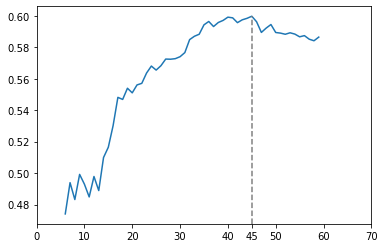

In [181]:
sqr_spike_dst = squareform(spike_dst)
sqr_isi_dst = squareform(isi_dst)

ward_spike = cluster.hierarchy.linkage(spike_dst, method='ward')
ward_isi = cluster.hierarchy.linkage(isi_dst, method='ward')

min_qclust = 6
max_qclust = 60

ncls = np.arange(min_qclust, max_qclust, 1)
metric_scores = np.zeros(ncls.shape[0])
for i, t in enumerate(ncls):
    cls_spike = cluster.hierarchy.fcluster(ward_spike, t=t, criterion='maxclust')
    cls_isi = cluster.hierarchy.fcluster(ward_isi, t=t, criterion='maxclust')
    metric_scores[i] = metrics.adjusted_mutual_info_score(cls_isi, cls_spike)
    
max_cls = np.argmax(metric_scores) + min_qclust
fig, ax = plt.subplots()
ax.plot(ncls, metric_scores)

ax.axvline(max_cls, ymin=0, ymax=(np.max(metric_scores) - ax.get_ylim()[0]) / np.diff(ax.get_ylim()),
           linestyle='--', color='gray')
if max_cls not in list(ax.get_xticks()):
    ax.set_xticks(list(ax.get_xticks()) + [max_cls])
print('Optimum clusters: {}'.format(max_cls))
fig.savefig('{}/mutual_inf.png'.format(cls_folder))

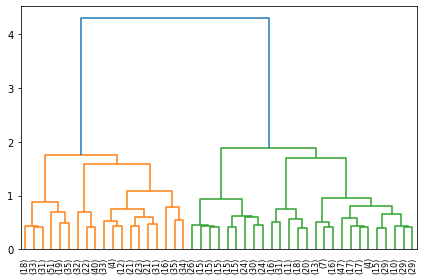

In [182]:
n_cluster = max_cls
cls_spike = cluster.hierarchy.fcluster(ward_spike, t=n_cluster, criterion='maxclust')
fig = plt.figure()
dn = cluster.hierarchy.dendrogram(ward_spike, p=np.unique(cls_spike).shape[0], distance_sort='ascending',
                                  truncate_mode='lastp')
plt.tight_layout()
fig.savefig('{}/dendogram.png'.format(cls_folder))

In [183]:
len(cls_spike)

1019

In [184]:
np.array(chirp_psth[0])

array([30.2926727 , 31.04489332, 31.7797519 , ..., 53.16516775,
       53.04107817, 52.90355832])

In [185]:
np.save('{}/exp_id.npy'.format(cls_folder), np.array(exp_unit))
np.save('{}/clust_result.npy'.format(cls_folder), np.array(cls_spike))


for i in range(1, max_cls + 1):
    if os.path.isdir('{}/{}'.format(cls_folder, i)) == False:
        os.mkdir('{}/{}'.format(cls_folder, i))
    
    cls_units = np.asarray(exp_unit, dtype='<U9')[cls_spike == i]
    cls_chirp = chirp_psth[cls_spike == i]
    cls_flash = flash_psth[cls_spike == i]

    for (uid, chirp, flash) in zip(cls_units, cls_chirp, cls_flash):
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        ax[0].plot(flash_time, flash)
        ax[1].plot(chirp_time, chirp)

        ax[0].set_title('{}, {} flash'.format(uid[0], uid[1]))
        ax[1].set_title('{}, {} chirp'.format(uid[0], uid[1]))
        
        fig.savefig('{}/{}/{} {}.png'.format(cls_folder, i, uid[0], uid[1]))
        
        [_ax.clear() for _ax in ax]
        fig.clf()
        fig.clear()
        plt.close()
                
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(flash_time, np.mean(cls_flash, axis=0))
    ax[1].plot(chirp_time, np.mean(cls_chirp, axis=0))
    ax[0].set_title('Mean flash')
    ax[1].set_title('Mean chirp')
    
    fig.savefig('{}/{}/clust{}_mean_resp.png'.format(cls_folder, i, i))
    
    [_ax.clear() for _ax in ax]
    fig.clf()
    fig.clear()
    plt.close()

In [186]:
if os.path.isdir('{}/mean'.format(cls_folder)) == False:
    os.mkdir('{}/mean'.format(cls_folder))
for i in range(1, max_cls + 1):
    shutil.copy('{}/{}/clust{}_mean_resp.png'.format(cls_folder, i, i), '{}/mean'.format(cls_folder))

In [187]:
n_cells=len(exp_unit)
ind = np.asarray(bias_index)

/home/brontodegus/anaconda3/envs/chirp/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1870: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


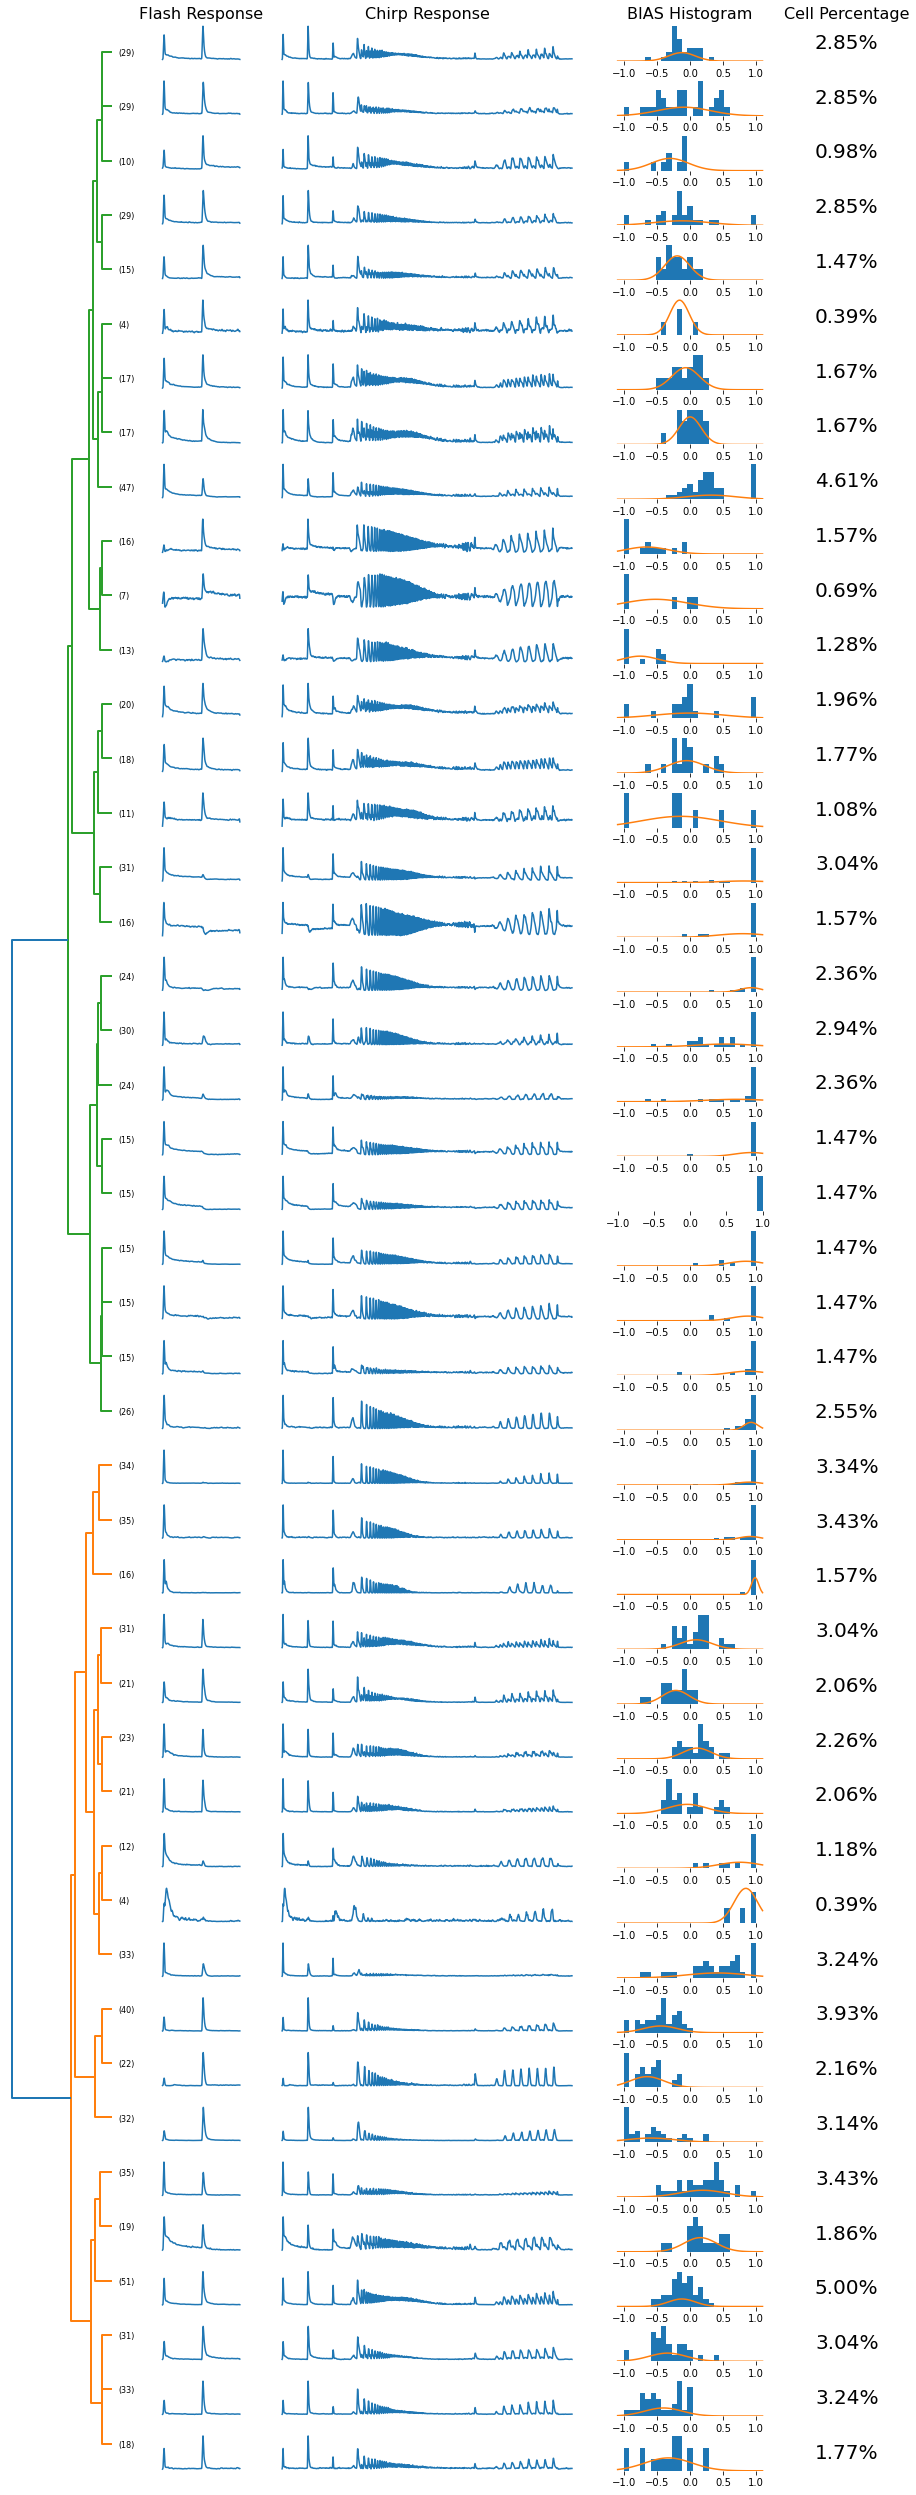

In [272]:
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d
from scipy.stats import norm

plt.figure(figsize=(16,max_cls*1))

plot_stims = [0,1]
plot_widths = [1.2, 0.8, 3, 1.5, 1]
fs=12
t = np.linspace(-1, 1, 100)

gs = gridspec.GridSpec(max_cls, 5, width_ratios = plot_widths, wspace=0.15, hspace=0.5)
for i in range(1,max_cls +1):
    cls_units = np.asarray(exp_unit, dtype='<U9')[cls_spike == i]
    cls_chirp = chirp_psth[cls_spike == i]
    cls_flash = flash_psth[cls_spike == i]
    cls_bias = ind[cls_spike == i]
    flash_mean = 0
    chirp_mean = 0
    bias_mean = []
    bias_mean_aux = []
    for (uid, chirp, flash, bias) in zip(cls_units, cls_chirp, cls_flash, cls_bias):
        flash_mean += flash
        chirp_mean += chirp
        if (not np.isnan(bias)):
            bias_mean.append(bias)
            bias_mean_aux.append(bias / 1000)
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        ax[0].plot(flash_time, flash)
        ax[1].plot(chirp_time, chirp)     
        [_ax.clear() for _ax in ax]
        fig.clf()
        fig.clear()
        plt.close()
    flash_mean=flash_mean/len(cls_units)
    chirp_mean=chirp_mean/len(cls_units)
    
    ax = plt.subplot(gs[(max_cls-(i)),3])
    ax.hist(bias_mean, bins = 25, range=[-1, 1])
    mean,std = norm.fit(bias_mean)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    y = norm.pdf(x, mean, std)
    ax.plot(x, y)
    if(i == max_cls):
        ax.set_title("BIAS Histogram", fontsize=16)
    #plt.xticks(())
    
    plt.yticks(())
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax = plt.subplot(gs[(max_cls-(i)),2])
    ax.plot(chirp_time, chirp_mean)
    if(i == max_cls):
        ax.set_title("Chirp Response", fontsize=16)
    plt.xticks(())
    plt.yticks(())
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax = plt.subplot(gs[(max_cls-(i)),1])
    ax.plot(flash_time, flash_mean)
    if(i == max_cls):
        ax.set_title("Flash Response", fontsize=16)
    plt.xticks(())
    plt.yticks(())
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax = plt.subplot(gs[(max_cls-(i)),4])
    if(i == max_cls):
        ax.set_title("Cell Percentage", fontsize=16)
    ax.text(0.2, 0.35, "{:.2f}%".format(100*(len(cls_units)/n_cells)) , fontsize=20)
    plt.xticks(())
    plt.yticks(())
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
ax = plt.subplot(gs[:,0])
p = ax.get_position()
p.x1 = p.x1-0.02
ax.set_position(p)
with plt.rc_context({'lines.linewidth': 2, 'font.size':fs, 'axes.titleweight': 'bold'}):
    dend = cluster.hierarchy.dendrogram(ward_spike, p=np.unique(cls_spike).shape[0], distance_sort='ascending',
                                  truncate_mode='lastp',orientation='left')

    
    ax.set_xticks(())
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.savefig('{}/dend_flash_chirp.png'.format(cls_folder))

In [231]:
max(bias_mean)

0.3359465392734172

8.4


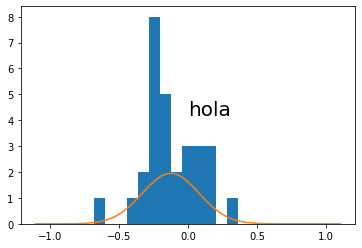

In [261]:
from scipy.ndimage.filters import gaussian_filter1d
from scipy.interpolate import interp1d
from scipy.stats import norm

t = np.linspace(-1, 1, len(psth))
t1 = np.linspace(-1, 1, 100)
f_cubic = interp1d(t, psth, kind='cubic')
mean,std = norm.fit(bias_mean)
color_resp = spkt.est_pdf([bias_mean] , t, )

plt.hist(bias_mean, bins = 25, range=[-1, 1])

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std)
plt.plot(x, y)

plt.text(0, ymax*0.5, "hola", fontsize=20)
print(ymax)


In [226]:
len(bias_mean)

29

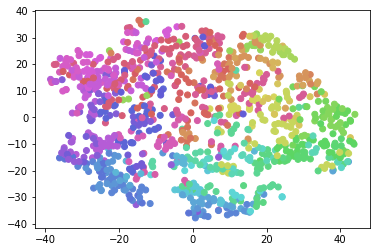

In [191]:
from matplotlib.colors import ListedColormap
fig, ax = plt.subplots()
# ax.plot(np.array(list(chirp_psth.values()))[0])

model = TSNE(n_components=2, random_state=0, perplexity=30)#,init='pca')
proj = model.fit_transform(chirp_psth)

n_flat_clusters = np.unique(cls_spike).shape[0]
show_order = np.unique(cls_spike)[::-1] - 1

ax.scatter(proj[:, 0], proj[:, 1], c=show_order[cls_spike - 1],
           cmap=ListedColormap(sns.hls_palette(n_flat_clusters, l=0.6, s=0.6).as_hex()))
fig.savefig('{}/tsne.png'.format(cls_folder))